# Modern DiD Approaches



In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyfixest as pf

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = "retina"

The data is from [Callaway (2022)](https://bcallaway11.github.io/files/Callaway-Chapter-2022/main.pdf), annual county level data from the United States covering 2001 to 2007. The outcome variable is log county-level teen employment, and the treatment variable is an indicator for whether the county has a minimum wage above the federal minimum wage. See [Callaway and Sant’Anna (2021)](https://www.sciencedirect.com/science/article/abs/pii/S0304407620303948) for additional details on the data.

In [31]:
url = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/minwage_data.csv"
data = pd.read_csv(url,index_col=0)

# Remove observations that are already treated in the first observed period (2001).
data = data.loc[(data.G == 0) | (data.G > 2001)]

# Drop all variables that we won't use
data.drop(columns=["countyreal", "state_name", "FIPS", "emp0A01_BS",
                   "quarter", "censusdiv", "pop", "annual_avg_pay",
                   "state_mw", "fed_mw", "ever_treated"], inplace=True)

data.head(10)

,year,treated,G,lemp,lpop,lavg_pay,region,id
554,2001,0,2007,5.556828,9.614137,10.057495,4,8003
555,2002,0,2007,5.356586,9.623972,10.097120,4,8003
556,2003,0,2007,5.389072,9.620859,10.107611,4,8003
557,2004,0,2007,5.356586,9.626548,10.140337,4,8003
558,2005,0,2007,5.303305,9.637958,10.175497,4,8003
559,2006,0,2007,5.342334,9.633056,10.218590,4,8003
560,2007,1,2007,5.220356,9.635412,10.289702,4,8003
561,2001,0,2007,5.198497,9.260368,10.021359,4,8007
562,2002,0,2007,5.262690,9.312265,10.031045,4,8007
563,2003,0,2007,5.278115,9.338118,10.071795,4,8007


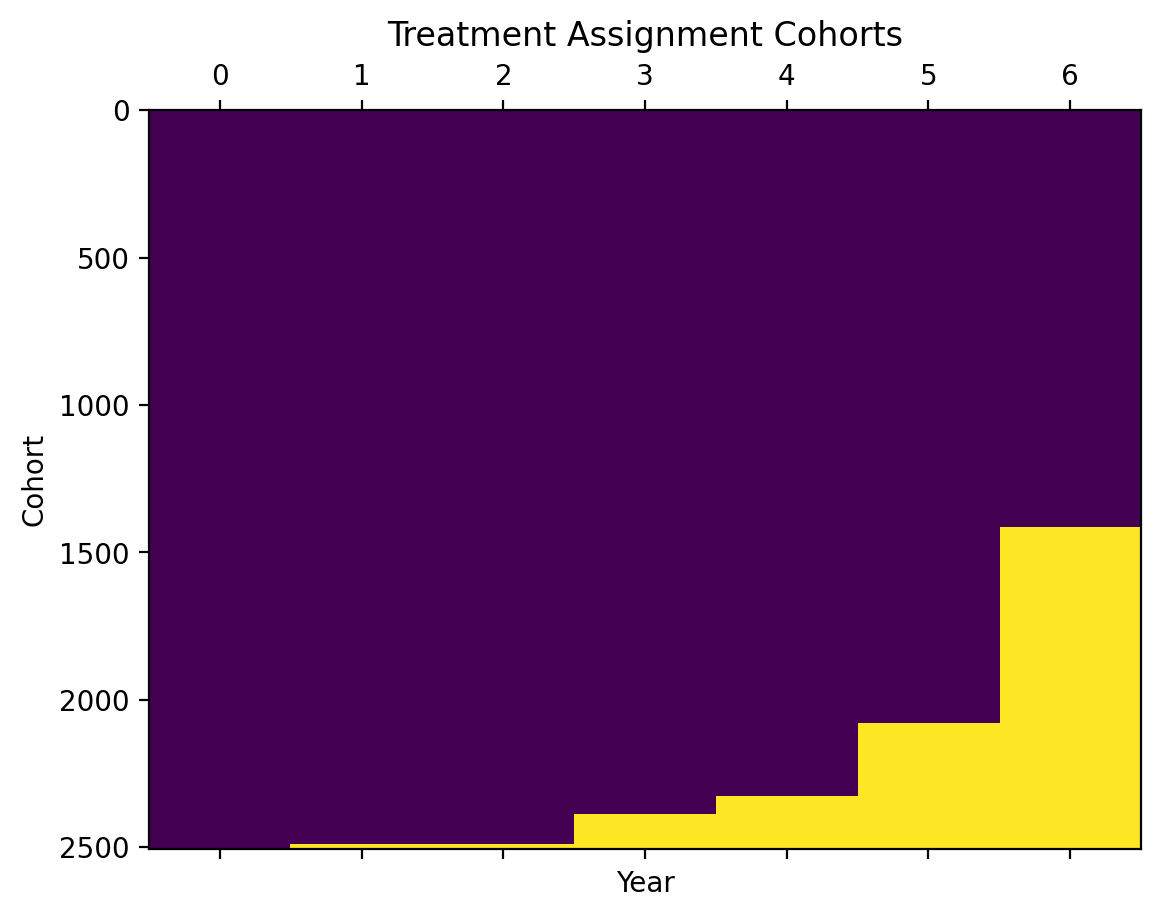

In [32]:
pf.panelview(
    data,
    unit="id",
    time="year",
    treat="treated",
    sort_by_timing=True,
    ylab="Cohort",
    xlab="Year",
    title="Treatment Assignment Cohorts",
    figsize=(0.5, 0.5),
)

plt.show()

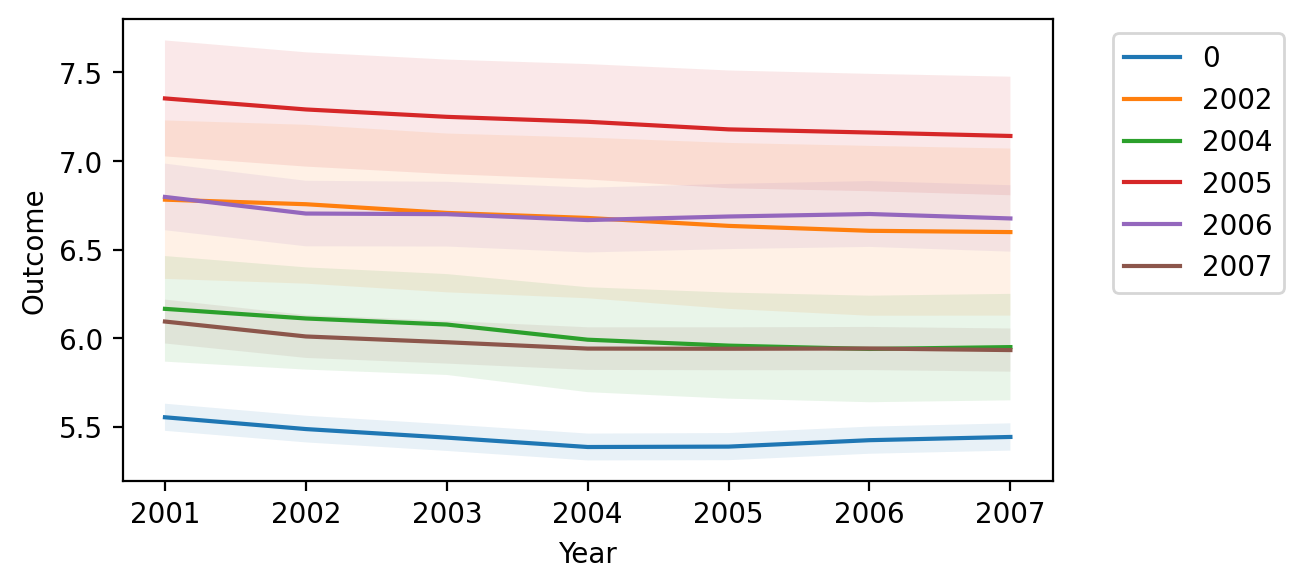

In [33]:
fig, ax = plt.subplots(figsize=(6, 3))

# Calculate means and standard errors
means = data.groupby(["year", "G"])["lemp"].mean().unstack()
std_errors = data.groupby(["year", "G"])["lemp"].sem().unstack()

# Plot means
means.plot(ax=ax)

# Add standard errors using for loop
for group in means.columns:
    ax.fill_between(means.index, means[group] - 1.96 * std_errors[group], means[group] + 1.96 * std_errors[group], alpha=0.1)

# Add legend, vertical line, labels, and show plot
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.xlabel("Year")
plt.ylabel("Outcome")
plt.show()

Even though we know the problems of using TWFE with staggered adoption, we will use it as a benchmark to compare with the other methods.

In [50]:
data['relative_year'] = np.where(data['G'] > 0, data['year'] - data['G'], -np.inf)

fit_twfe = pf.feols("lemp ~ i(relative_year, ref=-1.0) | id + year",
                    data, vcov={"CRV1": "id"})

fit_twfe.iplot(
    coord_flip=False,
    title="TWFE-Estimator",
    figsize=[800, 300],
    xintercept=4.5,
    yintercept=0,
    joint=True,
    labels=pf.report.utils.rename_event_study_coefs(fit_twfe._coefnames),  # rename coefficients
).show()

## Callaway and Sant'Anna (2020)

CS propose two ways of dealing with the negative weights. 

1. Compare average outcomes in any post-adoption period $(\bar{Y}_{t \mid a} \text{ for } t \geq a)$ to average outcomes for the same group immediately prior to the adoption $(\bar{Y}_{a-1 \mid a})$. Then, subtract the difference in outcomes for the same two time periods for the single group that never adopts the treatment $(a=\infty)$. Formally, for $t \geq a$, this double difference is
$$
\hat{\tau}_{t, a-1}^{a, \infty}=\left(\bar{Y}_{t \mid a}-\bar{Y}_{a-1 \mid a}\right)-\left(\bar{Y}_{t \mid \infty}-\bar{Y}_{a-1 \mid \infty}\right) .
$$

2. Same as above, but instead of using the group that never adopts the treatment as the control group, use the average of the groups that do adopt the treatment, but restrict this to those who adopt after period $t$. 
$$
\hat{\tau}_{t, a-1}^{a,>t} \equiv\left(\bar{Y}_{t \mid a}-\bar{Y}_{a-1 \mid a}\right)-\frac{1}{T-t} \sum_{a^{\prime}=t+1}^T\left(\bar{Y}_{t \mid a^{\prime}}-\bar{Y}_{a-1 \mid a^{\prime}}\right)
$$

3. Given these two estimators, CS suggest reporting averages over periods $t$ and adoption dates $a$, using a variety of possible weight functions $\omega(a, t)$. This leads to an average of treatment effects, over different adoption dates, at exactly $e$ periods after adoption, for their two control groups,
$$
\hat{\tau}^{\mathrm{CS}, \mathrm{I}}(e)=\sum_{a=2}^{T-e} \omega_e(a, t) \cdot \hat{\tau}_{t, a-1}^{a, \infty}, \quad \text { or } \quad \hat{\tau}^{\mathrm{CS}, \mathrm{II}}(e)=\sum_{a=2}^{T-e} \omega_e(a, t) \cdot \hat{\tau}_{t, a-1}^{a,>t} .
$$

A concern is that the control group that never adopts the treatment might be fundamentally different from the other groups and thus less suitable as a comparison for the trends in the absence of the treatment.

In [54]:
from csdid.att_gt import ATTgt

# estimate group-time average treatment effects without covariates
attgt = ATTgt(yname="lemp", gname="G", idname="id", tname="year",
              xformla=f"lemp~1", data=data).fit()
attgt.summ_attgt().summary2

,Group,Time,"ATT(g, t)",Post,Std. Error,[95% Pointwise,Conf. Band],
0,2002,2002,0.0408,1,0.0148,-0.0024,0.0841,
1,2002,2003,0.0400,1,0.0246,-0.0321,0.1121,
2,2002,2004,0.0646,1,0.0237,-0.0048,0.1341,
3,2002,2005,0.0176,1,0.0332,-0.0797,0.1149,
4,2002,2006,-0.0464,1,0.0425,-0.1710,0.0782,
5,2002,2007,-0.0718,1,0.0354,-0.1756,0.0319,
6,2004,2002,0.0122,0,0.0181,-0.0409,0.0654,
7,2004,2003,0.0142,0,0.0176,-0.0374,0.0657,
8,2004,2004,-0.0327,1,0.0269,-0.1117,0.0464,
9,2004,2005,-0.0683,1,0.0252,-0.1422,0.0056,


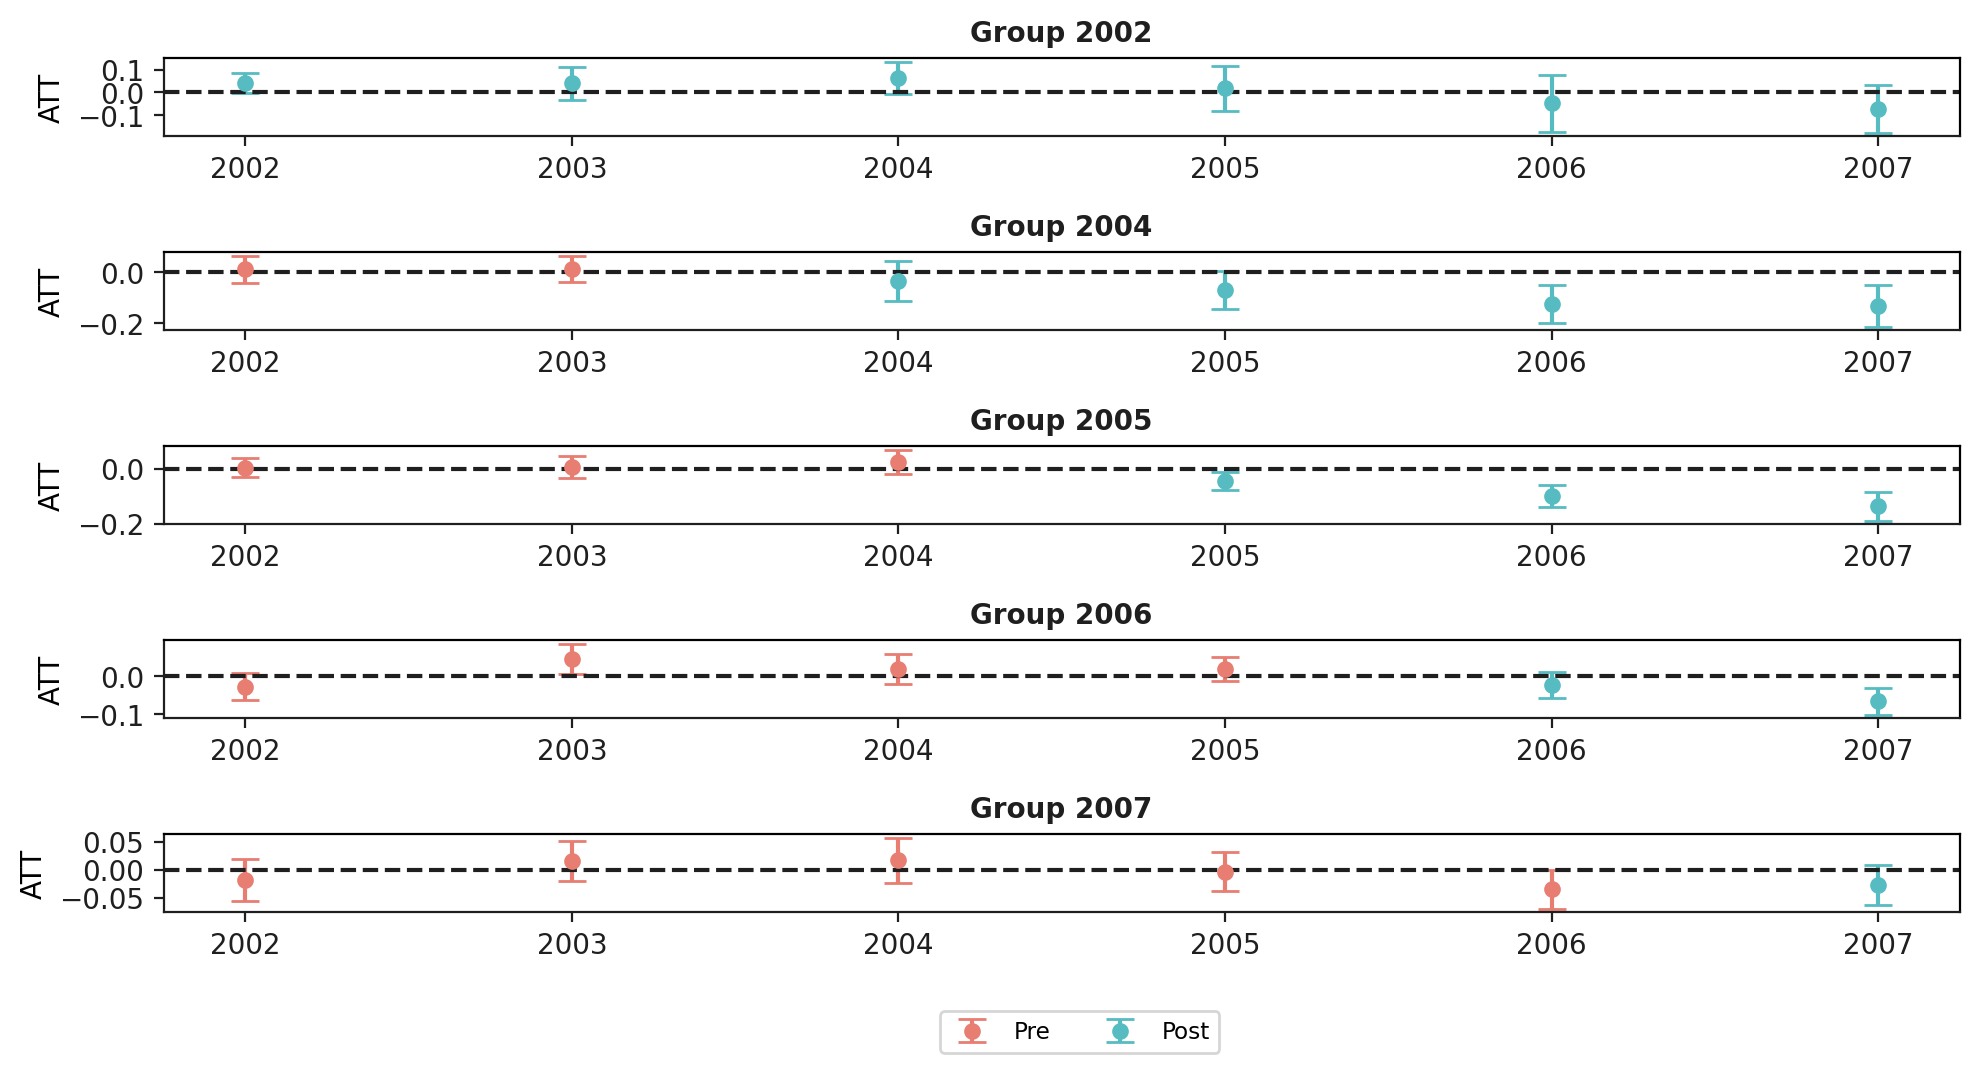

In [55]:
attgt.plot_attgt();

In [63]:
attgt.aggte("simple");



    ATT Std. Error  [95.0%  Conf. Int.]  
-0.0501     0.0079 -0.0657      -0.0346 *


---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust






Overall summary of ATT's based on group/cohort aggregation:
    ATT Std. Error [95.0%  Conf. Int.]  
-0.0399     0.0077 -0.055      -0.0249 *


Group Effects:
   Group  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0   2002    0.0075      0.0260          -0.0436      0.0585   
1   2004   -0.0888      0.0235          -0.1349     -0.0428  *
2   2005   -0.0937      0.0112          -0.1157     -0.0716  *
3   2006   -0.0439      0.0095          -0.0624     -0.0253  *
4   2007   -0.0271      0.0120          -0.0505     -0.0036  *
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




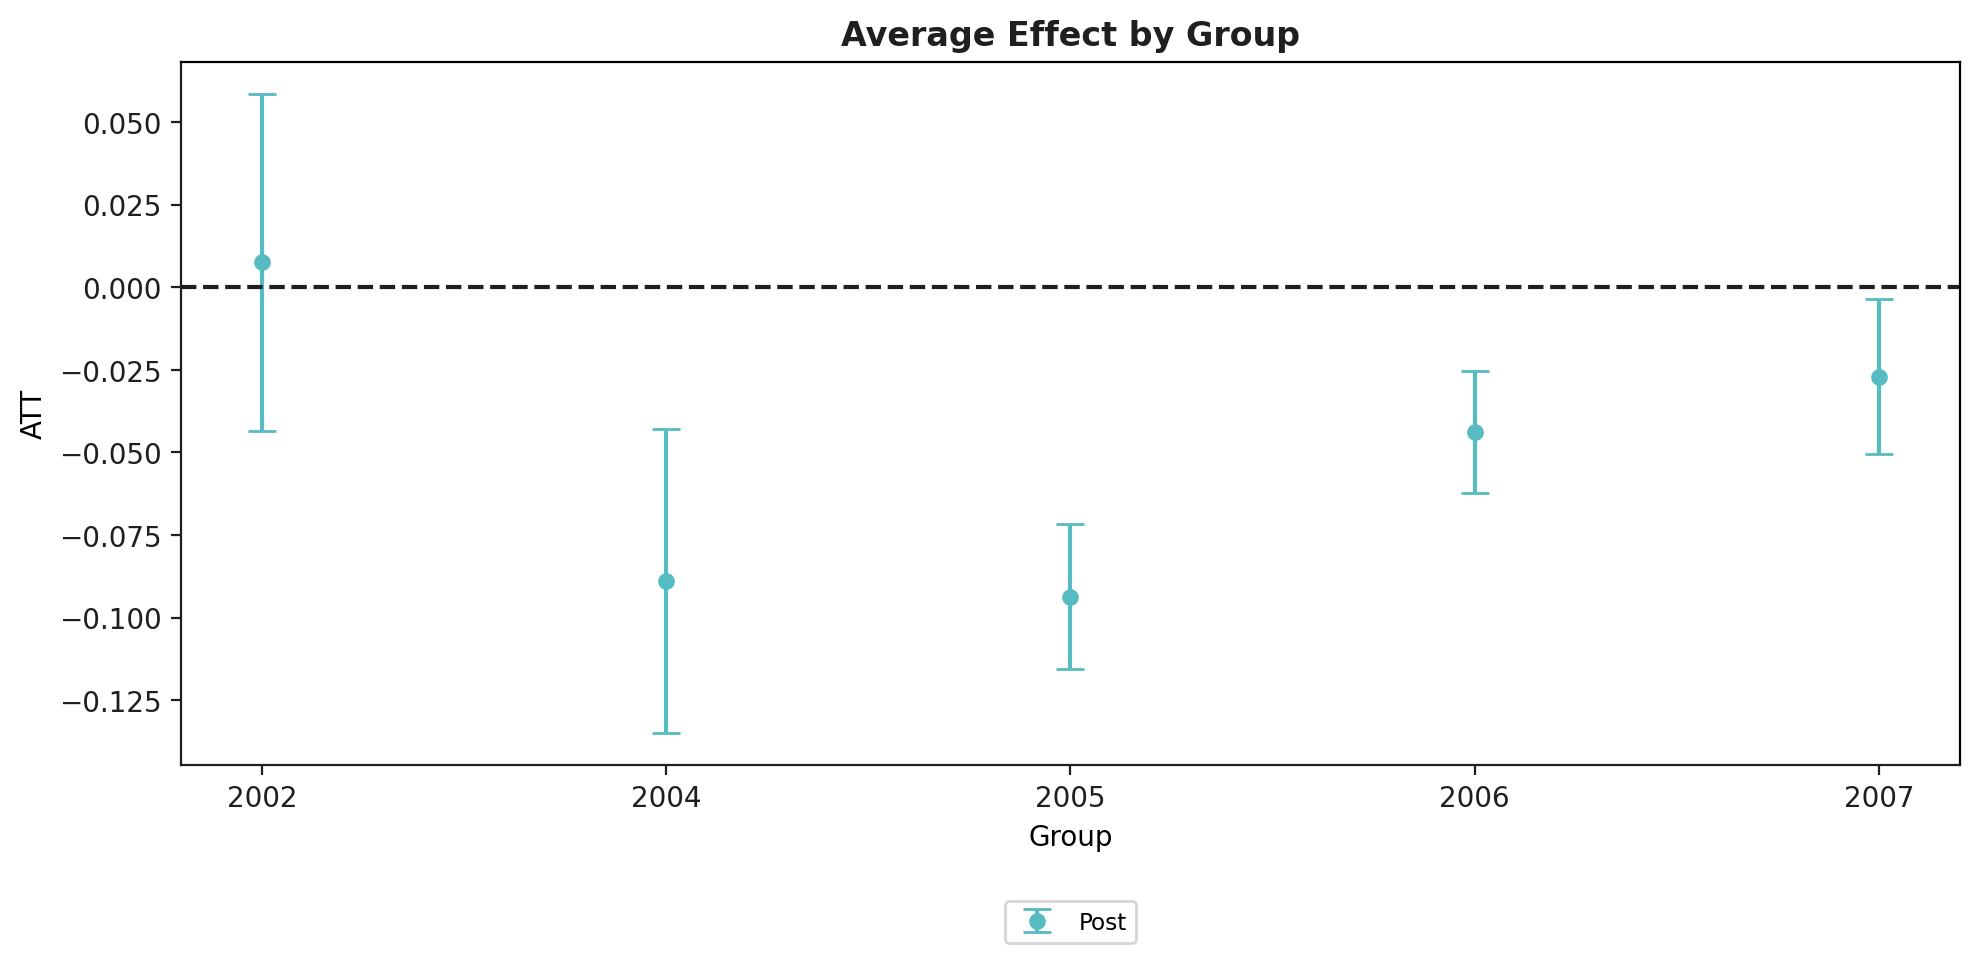

In [57]:
attgt.aggte("group")
attgt.plot_aggte();



Overall summary of ATT's based on calendar time aggregation:
   ATT Std. Error  [95.0%  Conf. Int.] 
-0.017     0.0094 -0.0354       0.0014 


Time Effects (calendar):
   Time  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0  2002    0.0408      0.0138           0.0138      0.0679  *
1  2003    0.0400      0.0247          -0.0084      0.0885   
2  2004   -0.0195      0.0240          -0.0664      0.0275   
3  2005   -0.0527      0.0164          -0.0848     -0.0206  *
4  2006   -0.0584      0.0106          -0.0792     -0.0377  *
5  2007   -0.0524      0.0089          -0.0698     -0.0350  *
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




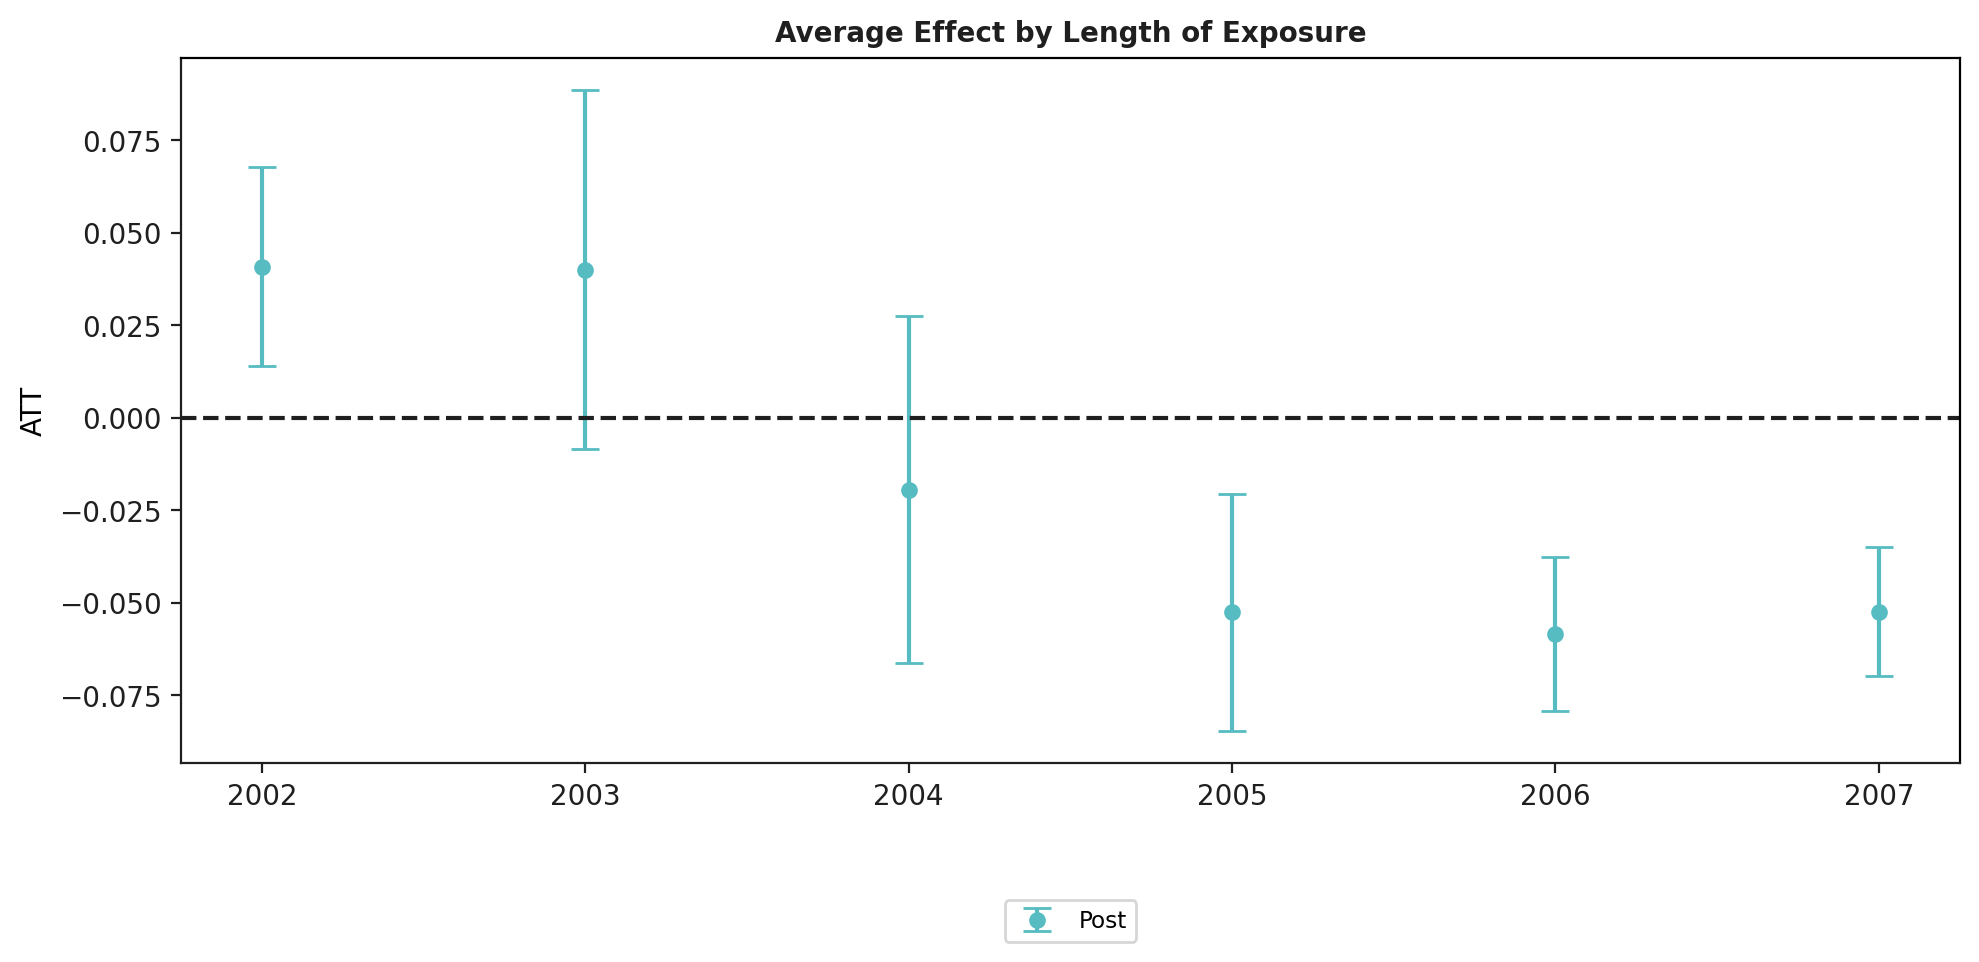

In [58]:
attgt.aggte('calendar')
attgt.plot_aggte();

What happen if we introduce covariates? And what if we use the not-yet-adopted group as control group?

In [ ]:
attgt_altcontrol = ATTgt(
    yname="Y",
    tname="period",
    idname="id",
    gname="G",
    xformla="Y~X",
    data=dta,
    control_group="notyettreated"
).fit()
attgt_altcontrol.summ_attgt().summary2